# Chapter 10 - Predicting Continuous Target Variables with Regression Analysis

### Overview

- [Introducing a simple linear regression model](#Introducing-a-simple-linear-regression-model)
- [Exploring the Housing Dataset](#Exploring-the-Housing-Dataset)
  - [Visualizing the important characteristics of a dataset](#Visualizing-the-important-characteristics-of-a-dataset)
- [Implementing an ordinary least squares linear regression model](#Implementing-an-ordinary-least-squares-linear-regression-model)
  - [Solving regression for regression parameters with gradient descent](#Solving-regression-for-regression-parameters-with-gradient-descent)
  - [Estimating the coefficient of a regression model via scikit-learn](#Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
- [Fitting a robust regression model using RANSAC](#Fitting-a-robust-regression-model-using-RANSAC)
- [Evaluating the performance of linear regression models](#Evaluating-the-performance-of-linear-regression-models)
- [Using regularized methods for regression](#Using-regularized-methods-for-regression)
- [Turning a linear regression model into a curve - polynomial regression](#Turning-a-linear-regression-model-into-a-curve---polynomial-regression)
  - [Modeling nonlinear relationships in the Housing Dataset](#Modeling-nonlinear-relationships-in-the-Housing-Dataset)
  - [Dealing with nonlinear relationships using random forests](#Dealing-with-nonlinear-relationships-using-random-forests)
    - [Decision tree regression](#Decision-tree-regression)
    - [Random forest regression](#Random-forest-regression)
- [Summary](#Summary)

<br>
<br>

In [6]:
from IPython.display import Image
%matplotlib inline

# Introducing a simple linear regression model

#### Univariate Model

$$
   y = w_0 + w_1 x
$$

Relationship between 
- a single feature (**explanatory variable**) $x$
- a continous target (**response**) variable $y$

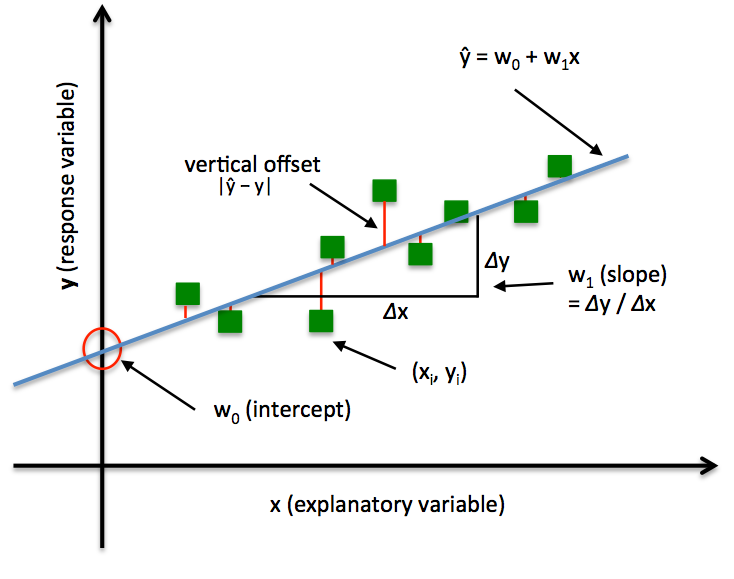

In [7]:
Image(filename='./images/10_01.png', width=500) 

- **regression line** : the best-fit line
- **offsets** or **residuals**: the gap between the regression line and the sample points

#### Multivariate Model
$$
   y = w_0 + w_1 x_1 + \dots + w_m x_m
$$

<br>
<br>

# Exploring the Housing dataset

- Information about houses in the suburbs of Boston
- Collected by D. Harrison and D.L. Rubinfeld in 1978
- 506 samples

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
</pre>

We'll consider **MEDV** as our target variable.

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<br>
<br>

## Visualizing the important characteristics of a dataset

#### Scatter plot matrix

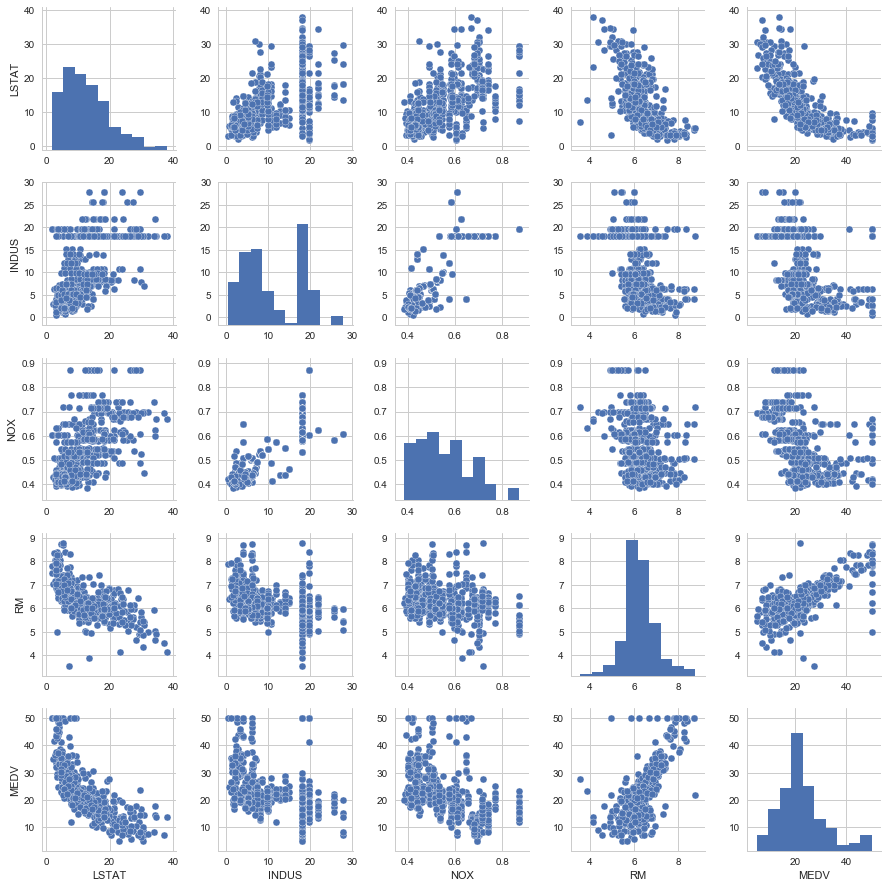

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

#### Correlation Matrix

- a scaled version of the covariance matrix
- each entry contains the **Pearson product-moment correlation coefficients** (**Pearson's r**)
- quantifies **linear** relationship between features
- ranges in $[-1,1]$
  - $r=1$ perfect positive correlation
  - $r=0$ no correlation
  - $r=-1$ perfect negative correlation

$$
     r = \frac{
       \sum_{i=1}^n [(x^{(i)}-\mu_x)(y^{(i)}-\mu_y)]
     }{
     \sqrt{\sum_{i=1}^n (x^{(i)}-\mu_x)^2}
     \sqrt{\sum_{i=1}^n (y^{(i)}-\mu_y)^2}
     } =
     \frac{\sigma_{xy}}{\sigma_x\sigma_y}
$$

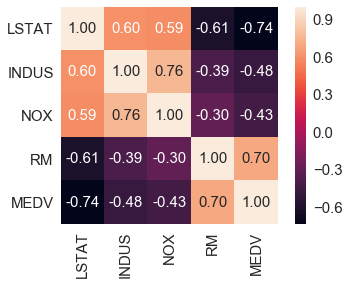

In [4]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

- MEDV has large correlation with LSTAT and RM
  - The relation between MEDV ~ LSTAT may not be linear
  - The relation between MEDV ~ RM looks liinear

In [5]:
sns.reset_orig()
%matplotlib inline

<br>
<br>

# Implementing an ordinary least squares (OLS) linear regression model

## Solving regression for regression parameters with gradient descent

#### OLS Cost Function (Sum of Squred Errors, SSE)
$$
  J(w) = \frac12 \sum_{i=1}^n (y^{(i)} - \hat y^{(i)})^2 = \frac12 \| y - Xw - \mathbb{1}w_0\|^2
$$

- $\hat y^{(i)} = w^T x^{(i)} $ is the predicted value
- OLS linear regression can be understood as Adaline without the step function, which converts the linear response $w^T x$ into $\{-1,1\}$. 

#### Gradient Descent (refresh)
$$
    w_{k+1} = w_k - \eta_k \nabla J(w_k), \;\; k=1,2,\dots
$$
- $\eta_k>0$ is the learning rate
- $$
 \nabla J(w_k) = 
 \begin{bmatrix} -X^T(y-Xw- \mathbb{1}w_0) \\
  -\mathbb{1}^T(y-Xw- \mathbb{1}w_0)
 \end{bmatrix}
$$

In [6]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [7]:
X = df[['RM']].values
y = df[['MEDV']].values

In [8]:
y.shape

(506, 1)

In [9]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
#y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
y_std = sc_y.fit_transform(y).flatten()


In [10]:
y_std.shape

(506,)

In [11]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

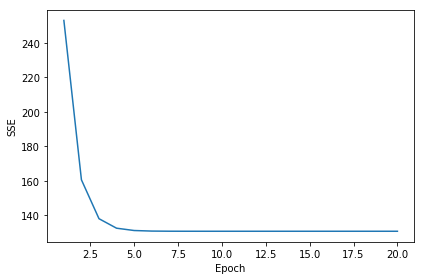

In [12]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

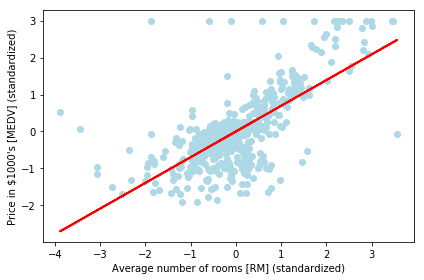

In [14]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

In [15]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [16]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


<br>
<br>

## Estimating the coefficient of a regression model via scikit-learn

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


The solution is different from the previous result, since the data is **not** normalized here.

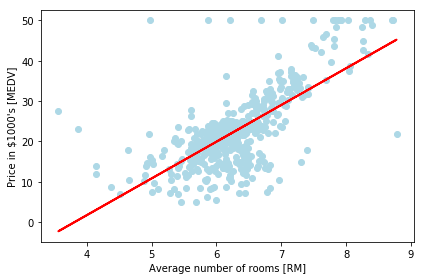

In [19]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

<br>
<br>

# Fitting a robust regression model using RANSAC (RANdom SAmple Consensus)

- Linear regression models can be heavily affected by outliers
- A very small subset of data can have a big impact on the estimated model coefficients
- Removing outliers is not easy

RANSAC algorithm:

1. Select a random subset of samples to be *inliers* and fit the model
2. Test all other data points against the fitted model, and add those points that fall within a user-defined tolerance to inliers
3. Refit the model using all inliers.
4. Estimate the error of the fitted model vs. the inliers
5. Terminate if the performance meets a user-defined threshold, or if a fixed number of iterations has been reached.

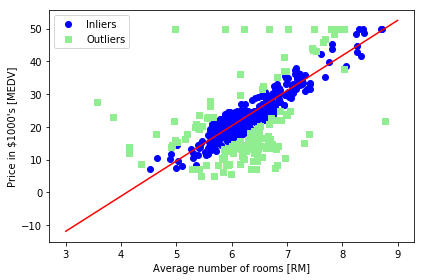

In [20]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, # problem-specific
                         random_state=0)


ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [21]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


<br>
<br>

# Evaluating the performance of linear regression models

In [22]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [23]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#### Residual Plot

- It's not easy to plot linear regression line in general, since the model uses multiple explanatory variables
- Residual plots are used for:
  - detect nonlinearity
  - detect outliers
  - check if errors are randomly distributed

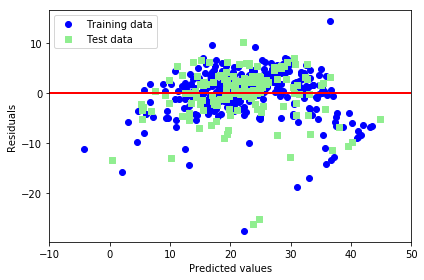

In [24]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

If we see patterns in residual plot, it implies that our model didn't capture some explanatory information which leaked into the pattern.

#### MSE (Mean-Square Error)
$$
 \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left( y^{(i)} - \hat y^{(i)} \right)^2
$$

#### $R^2$ score

- The fraction of variance captured by the model
- $R^2=1$ : the model fits the data perfectly

$$
R^2 = 1 - \frac{SSE}{SST}, \;\; SST = \sum_{i=1}^n \left( y^{(i)}-\mu_y\right)^2
$$

$$
R^2 = 1 - \frac{MSE}{Var(y)}
$$

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


The gap in MSE (between train and test) indicates overfitting

<br>
<br>

# Using regularized methods for regression

#### Ridge Regression
$$
 J(w) = \frac12 \sum_{i=1}^n (y^{(i)}-\hat y^{(i)})^2 + \lambda \|w\|_2^2
$$

#### LASSO (Least Absolute Shrinkage and Selection Operator)
$$
 J(w) = \frac12 \sum_{i=1}^n (y^{(i)}-\hat y^{(i)})^2 + \lambda \|w\|_1
$$

#### Elastic-Net
$$
 J(w) = \frac12 \sum_{i=1}^n (y^{(i)}-\hat y^{(i)})^2 + \lambda_1 \|w\|_2^2 + \lambda_2 \|w\|_1
$$


In [31]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
enet = ElasticNet(alpha=1.0, l1_ratio=0.5)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
enet.fit(X_train, y_train)

#y_train_pred = lasso.predict(X_train)
y_test_pred_r = ridge.predict(X_test)
y_test_pred_l = lasso.predict(X_test)
y_test_pred_e = enet.predict(X_test)
print("Ridge = ", ridge.coef_)
print("LASSO = ", lasso.coef_)
print("ENET = ",enet.coef_)

Ridge =  [ -1.18308575e-01   4.61259764e-02  -2.08626416e-02   2.45868617e+00
  -8.25958494e+00   3.89748516e+00  -1.79140171e-02  -1.39737175e+00
   2.18432298e-01  -1.16338128e-02  -9.31711410e-01   7.26996266e-03
  -4.94046539e-01]
LASSO =  [-0.06586193  0.04832933 -0.          0.         -0.          0.86898466
  0.01217999 -0.75109378  0.2000743  -0.01395062 -0.84602363  0.00668818
 -0.73266568]
ENET =  [-0.08344408  0.05179376 -0.01702468  0.         -0.          0.90890973
  0.01218953 -0.83010765  0.23558231 -0.01502425 -0.84881663  0.00687826
 -0.72504946]


In [32]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


<br>
<br>

# Turning a linear regression model into a curve - polynomial regression

$$
 y = w_0 + w_1 x + w_2 x^2 + \dots + w_d x^d
$$

In [33]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [34]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

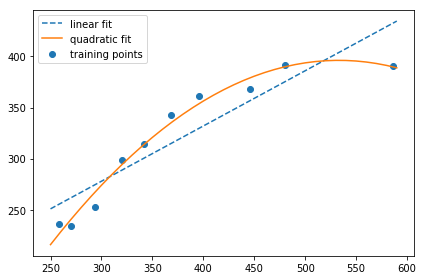

In [35]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

In [36]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [37]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


<br>
<br>

## Modeling nonlinear relationships in the Housing Dataset

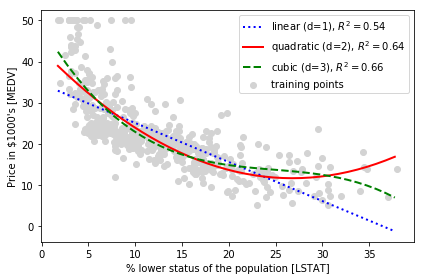

In [38]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

As the model complexity increases, the chance of overfitting increases as well

Transforming the dataset:

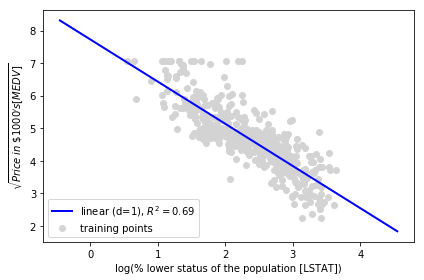

In [39]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

<br>
<br>

# Dealing with nonlinear relationships using random forests

We use Information Gain (IG) to find the feature to split, which will lead to the maximal IG:

$$
  IG(D_p, x_i) = I(D_p) - \frac{N_{left}}{N_p} I(D_{left}) - \frac{N_{right}}{N_p} I(D_{right})
$$

where $I$ is the impurity measure.

We've used e.g. entropy for discrete features. Here, we use MSE at node $t$ instead for continuous features:

$$
  I(t) = MSE(t) = \frac{1}{N_t} \sum_{i \in D_t} (y^{(i)} - \bar y_t)^2
$$
where $\bar y_t$ is the sample mean, 
$$
 \bar y_t = \frac{1}{N_t} \sum_{i \in D_t} y^{(i)}
$$

## Decision tree regression

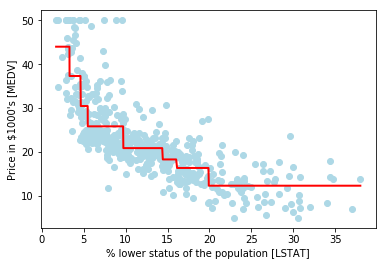

R^2 =  0.699383308564


In [46]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

r2 = r2_score(y, tree.predict(X))
print("R^2 = ", r2)

Disadvantage: it does not capture the continuity and differentiability of the desired prediction

<br>
<br>

## Random forest regression

Advantages:
- better generalization than individual trees
- less sensitive to outliers in the dataset
- don't require much parameter tuning

In [47]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [48]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


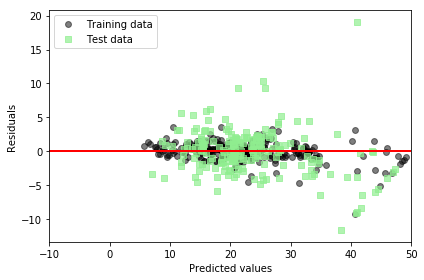

In [49]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

<br>
<br>

# Summary

- Univariate and multivariate linear models
- RANSAC to deal with outliers
- Regularization: control model complexity to avoid overfitting